### 1. Import Libraries

In [1]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

### 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output="pandas")

In [4]:
warnings.filterwarnings("ignore")

### 3. Read the Data

In [5]:
file_path = r"D:\Data Science\Machine Learning\Flight Price Prediction using AWS Sagemaker\Datasets\train.csv"
train = pd.read_csv(file_path)

In [6]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-05-21,Delhi,Cochin,05:35:00,08:50:00,195,0.0,No Info,5601
1,Jet Airways,2019-05-21,Kolkata,Banglore,14:05:00,22:35:00,510,1.0,No Info,14781
2,Jet Airways,2019-05-01,Kolkata,Banglore,18:55:00,04:40:00,585,1.0,In-flight meal not included,8586
3,Multiple Carriers,2019-03-27,Delhi,Cochin,08:55:00,15:30:00,395,1.0,No Info,7845
4,Air India,2019-03-18,Delhi,Cochin,05:10:00,08:00:00,170,0.0,No Info,5674
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,2019-06-01,Delhi,Cochin,07:05:00,19:15:00,730,1.0,In-flight meal not included,12927
636,Indigo,2019-06-12,Delhi,Cochin,16:00:00,21:00:00,300,1.0,No Info,6069
637,Air Asia,2019-06-21,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
638,Multiple Carriers,2019-06-06,Delhi,Cochin,11:25:00,19:15:00,470,1.0,No Info,7354


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [8]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

### 4. Transformation Operations

#### 4.1 airline

In [9]:
X_train.airline

0                 Indigo
1            Jet Airways
2            Jet Airways
3      Multiple Carriers
4              Air India
             ...        
635    Multiple Carriers
636               Indigo
637             Air Asia
638    Multiple Carriers
639             Spicejet
Name: airline, Length: 640, dtype: object

In [10]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,0.0,1.0,0.0
636,0.0,1.0,0.0,0.0,0.0
637,0.0,0.0,0.0,0.0,1.0
638,0.0,0.0,0.0,1.0,0.0


#### 4.2 date_of_journey

In [11]:
X_train.date_of_journey

0      2019-05-21
1      2019-05-21
2      2019-05-01
3      2019-03-27
4      2019-03-18
          ...    
635    2019-06-01
636    2019-06-12
637    2019-06-21
638    2019-06-06
639    2019-05-18
Name: date_of_journey, Length: 640, dtype: object

In [12]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.705882,0.166667,0.686441
1,0.666667,0.705882,0.166667,0.686441
2,0.666667,0.529412,0.333333,0.516949
3,0.000000,0.235294,0.333333,0.220339
4,0.000000,0.176471,0.000000,0.144068
...,...,...,...,...
635,1.000000,0.764706,0.833333,0.779661
636,1.000000,0.882353,0.333333,0.872881
637,1.000000,0.941176,0.666667,0.949153
638,1.000000,0.823529,0.500000,0.822034


#### 4.3 source & destination

In [13]:
X_train.source

0         Delhi
1       Kolkata
2       Kolkata
3         Delhi
4         Delhi
         ...   
635       Delhi
636       Delhi
637    Banglore
638       Delhi
639     Chennai
Name: source, Length: 640, dtype: object

In [14]:
X_train.destination

0        Cochin
1      Banglore
2      Banglore
3        Cochin
4        Cochin
         ...   
635      Cochin
636      Cochin
637       Delhi
638      Cochin
639     Kolkata
Name: destination, Length: 640, dtype: object

In [15]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Kolkata,Banglore
2,Kolkata,Banglore
3,Delhi,Cochin
4,Delhi,Cochin
...,...,...
635,Delhi,Cochin
636,Delhi,Cochin
637,Banglore,Delhi
638,Delhi,Cochin


In [16]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.007384,1.008186
1,0.028425,0.060251
2,0.028425,0.060251
3,1.007384,1.008186
4,1.007384,1.008186
...,...,...
635,1.007384,1.008186
636,1.007384,1.008186
637,-1.019887,-1.639131
638,1.007384,1.008186


In [17]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [18]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,0,1
638,1,0


In [19]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.007384,1.008186,1,0
1,0.028425,0.060251,1,0
2,0.028425,0.060251,1,0
3,1.007384,1.008186,1,0
4,1.007384,1.008186,1,0
...,...,...,...,...
635,1.007384,1.008186,1,0
636,1.007384,1.008186,1,0
637,-1.019887,-1.639131,0,1
638,1.007384,1.008186,1,0


#### 4.4 dep_time & arrival_time

In [20]:
X_train.dep_time

0      05:35:00
1      14:05:00
2      18:55:00
3      08:55:00
4      05:10:00
         ...   
635    07:05:00
636    16:00:00
637    04:55:00
638    11:25:00
639    17:45:00
Name: dep_time, Length: 640, dtype: object

In [21]:
X_train.arrival_time

0      08:50:00
1      22:35:00
2      04:40:00
3      15:30:00
4      08:00:00
         ...   
635    19:15:00
636    21:00:00
637    07:45:00
638    19:15:00
639    20:05:00
Name: arrival_time, Length: 640, dtype: object

In [22]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,05:35:00,08:50:00
1,14:05:00,22:35:00
2,18:55:00,04:40:00
3,08:55:00,15:30:00
4,05:10:00,08:00:00
...,...,...
635,07:05:00,19:15:00
636,16:00:00,21:00:00
637,04:55:00,07:45:00
638,11:25:00,19:15:00


In [23]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.217391,0.636364,0.347826,0.909091
1,0.608696,0.090909,0.956522,0.636364
2,0.782609,1.000000,0.173913,0.727273
3,0.347826,1.000000,0.652174,0.545455
4,0.217391,0.181818,0.347826,0.000000
...,...,...,...,...
635,0.304348,0.090909,0.826087,0.272727
636,0.695652,0.000000,0.913043,0.000000
637,0.173913,1.000000,0.304348,0.818182
638,0.478261,0.454545,0.826087,0.272727


In [24]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive="left"),
                 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
                 X_temp.loc[:, col].between(eve, night, inclusive="left")],
                ["morning", "afternoon", "evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,morning
1,afternoon,night
2,evening,morning
3,morning,afternoon
4,morning,morning
...,...,...
635,morning,evening
636,evening,night
637,morning,morning
638,morning,evening


In [25]:
time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.00000,1.000000
1,0.00000,0.988095
2,0.13964,1.000000
3,1.00000,0.000000
4,1.00000,1.000000
...,...,...
635,1.00000,0.583333
636,0.13964,0.988095
637,1.00000,1.000000
638,1.00000,0.583333


In [26]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.217391,0.636364,0.347826,0.909091,1.00000,1.000000
1,0.608696,0.090909,0.956522,0.636364,0.00000,0.988095
2,0.782609,1.000000,0.173913,0.727273,0.13964,1.000000
3,0.347826,1.000000,0.652174,0.545455,1.00000,0.000000
4,0.217391,0.181818,0.347826,0.000000,1.00000,1.000000
...,...,...,...,...,...,...
635,0.304348,0.090909,0.826087,0.272727,1.00000,0.583333
636,0.695652,0.000000,0.913043,0.000000,0.13964,0.988095
637,0.173913,1.000000,0.304348,0.818182,1.00000,1.000000
638,0.478261,0.454545,0.826087,0.272727,1.00000,0.583333


#### 4.5 duration

In [27]:
X_train.duration

0      195
1      510
2      585
3      395
4      170
      ... 
635    730
636    300
637    170
638    470
639    140
Name: duration, Length: 640, dtype: int64

In [28]:
(
    X_train
    .duration
    .quantile([0.25, 0.5, 0.75])
    .values
    .reshape(-1, 1)
    # .shape
)

array([[170.  ],
       [480.  ],
       [916.25]])

In [29]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma


    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }
        return self


    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)

In [30]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,0.904837,0.904837
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,1.000000,1.000000
3,1.140778e-167,0.0,1.000000,1.000000
4,0.000000e+00,0.0,0.904837,0.904837
...,...,...,...,...
635,0.000000e+00,0.0,1.000000,1.000000
636,5.073772e-48,0.0,1.000000,1.000000
637,0.000000e+00,0.0,0.904837,0.904837
638,0.000000e+00,0.0,1.000000,1.000000


In [31]:
def duration_category(X, short=180, med=400):
    return (
        X
        .assign(duration_cat=np.select([X.duration.lt(short),
                                        X.duration.between(short, med, inclusive="left")],
                                       ["short", "medium"],
                                       default="long"))
        .drop(columns="duration")
    )

In [32]:
def is_over(X, value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )

In [33]:
duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.392971,-0.089653,-0.084266,1.0,0,-0.857707
1,-0.392971,-0.089653,-0.084266,2.0,0,-0.229538
2,-0.392971,-0.089653,-0.084266,2.0,0,-0.079974
3,-0.392971,-0.089653,-0.084266,1.0,0,-0.458869
4,2.945672,-0.089653,-0.084266,0.0,0,-0.907562
...,...,...,...,...,...,...
635,-0.392971,-0.089653,-0.084266,2.0,0,0.209183
636,-0.392971,-0.089653,-0.084266,1.0,0,-0.648317
637,2.945672,-0.089653,-0.084266,0.0,0,-0.907562
638,-0.392971,0.056887,-0.084266,2.0,0,-0.309305


#### 4.6 total_stops

In [34]:
X_train.total_stops

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
635    1.0
636    1.0
637    0.0
638    1.0
639    0.0
Name: total_stops, Length: 640, dtype: float64

In [35]:
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))

total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,1.0,0
3,1.0,0
4,0.0,1
...,...,...
635,1.0,0
636,1.0,0
637,0.0,1
638,1.0,0


#### 4.7 additional_info

In [36]:
X_train.additional_info

0                          No Info
1                          No Info
2      In-flight meal not included
3                          No Info
4                          No Info
                  ...             
635    In-flight meal not included
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [37]:
info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,1.0,0.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [38]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [39]:
info_union = FeatureUnion(transformer_list=[
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func=have_info))
])

In [40]:
info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,1.0,0.0,0.0,1
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


#### 4.8 Column Transformer

In [41]:
column_transformer = ColumnTransformer(transformers=[
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source", 'destination']),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
], remainder="passthrough")

transformed_data = column_transformer.fit_transform(X_train, y_train)

In [42]:
transformed_data

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,1.007384,1.008186,1,0,0.217391,0.636364,0.347826,0.909091,1.00000,1.000000,-0.392971,-0.089653,-0.084266,1.0,0,-0.857707,0.0,1,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,0.028425,0.060251,1,0,0.608696,0.090909,0.956522,0.636364,0.00000,0.988095,-0.392971,-0.089653,-0.084266,2.0,0,-0.229538,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,0.028425,0.060251,1,0,0.782609,1.000000,0.173913,0.727273,0.13964,1.000000,-0.392971,-0.089653,-0.084266,2.0,0,-0.079974,1.0,0,1.0,0.0,0.0,1
3,0.0,0.0,0.0,1.0,0.0,0.000000,0.235294,0.333333,0.220339,1.007384,1.008186,1,0,0.347826,1.000000,0.652174,0.545455,1.00000,0.000000,-0.392971,-0.089653,-0.084266,1.0,0,-0.458869,1.0,0,0.0,1.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,0.000000,0.176471,0.000000,0.144068,1.007384,1.008186,1,0,0.217391,0.181818,0.347826,0.000000,1.00000,1.000000,2.945672,-0.089653,-0.084266,0.0,0,-0.907562,0.0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,1.0,0.0,1.000000,0.764706,0.833333,0.779661,1.007384,1.008186,1,0,0.304348,0.090909,0.826087,0.272727,1.00000,0.583333,-0.392971,-0.089653,-0.084266,2.0,0,0.209183,1.0,0,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,1.007384,1.008186,1,0,0.695652,0.000000,0.913043,0.000000,0.13964,0.988095,-0.392971,-0.089653,-0.084266,1.0,0,-0.648317,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,0.0,0.0,1.0,1.000000,0.941176,0.666667,0.949153,-1.019887,-1.639131,0,1,0.173913,1.000000,0.304348,0.818182,1.00000,1.000000,2.945672,-0.089653,-0.084266,0.0,0,-0.907562,0.0,1,0.0,1.0,0.0,0
638,0.0,0.0,0.0,1.0,0.0,1.000000,0.823529,0.500000,0.822034,1.007384,1.008186,1,0,0.478261,0.454545,0.826087,0.272727,1.00000,0.583333,-0.392971,0.056887,-0.084266,2.0,0,-0.309305,1.0,0,0.0,1.0,0.0,0


### 5. Feature Selection

In [43]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",
    threshold=0.095
) 

### 6. Putting it all Together

In [44]:
preprocessor = Pipeline(steps=[
    ("ct", column_transformer),
    ("selector", selector)
])

temp = preprocessor.fit_transform(X_train, y_train)

In [45]:
# temp['doj__date_of_journey_week'] = transformed_data['doj__date_of_journey_week']

In [46]:
temp

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.0,0.686441,1.007384,1.008186,-0.392971,1.0,0,-0.857707,0.0,1
1,0.0,1.0,0.0,0.686441,0.028425,0.060251,-0.392971,2.0,0,-0.229538,1.0,0
2,0.0,1.0,0.0,0.516949,0.028425,0.060251,-0.392971,2.0,0,-0.079974,1.0,0
3,0.0,0.0,0.0,0.220339,1.007384,1.008186,-0.392971,1.0,0,-0.458869,1.0,0
4,0.0,0.0,0.0,0.144068,1.007384,1.008186,2.945672,0.0,0,-0.907562,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.779661,1.007384,1.008186,-0.392971,2.0,0,0.209183,1.0,0
636,1.0,0.0,0.0,0.872881,1.007384,1.008186,-0.392971,1.0,0,-0.648317,1.0,0
637,0.0,0.0,1.0,0.949153,-1.019887,-1.639131,2.945672,0.0,0,-0.907562,0.0,1
638,0.0,0.0,0.0,0.822034,1.007384,1.008186,-0.392971,2.0,0,-0.309305,1.0,0


In [47]:
# columns = list(temp.columns)
# columns.insert(columns.index('doj__date_of_journey_day_of_year'), columns.pop(columns.index('doj__date_of_journey_week')))
# new_df = temp[columns]

In [48]:
# new_df

### 7. Visualizations

In [49]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.0005209486403792521,
 'air__airline_Indigo': 0.14274968013910758,
 'air__airline_Jet Airways': 0.21392262427499428,
 'air__airline_Multiple Carriers': 0.02292998316402291,
 'air__airline_Other': 0.13491691742111614,
 'doj__date_of_journey_month': 0.07477415597858972,
 'doj__date_of_journey_week': 0.09722394233647584,
 'doj__date_of_journey_day_of_week': 0.0026479004492815004,
 'doj__date_of_journey_day_of_year': 0.1287478491590642,
 'location__source': 0.2235332101293747,
 'location__destination': 0.19491637392106284,
 'location__source_is_north': 0.06328110480929416,
 'location__destination_is_north': 0.06328110480929416,
 'time__dep_time_hour': -0.024260585281293007,
 'time__dep_time_minute': 0.025319231974472983,
 'time__arrival_time_hour': 0.09241530987021367,
 'time__arrival_time_minute': 0.016381166896216603,
 'time__dep_time_part_of_day': -0.01756031833912519,
 'time__arrival_time_part_of_day': 0.060354100131385126,
 'dur__duration_rbf_25': 0.135477

In [50]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_hour': -0.024260585281293007,
 'time__dep_time_part_of_day': -0.01756031833912519,
 'info__additional_info_No Info': -0.006905182575103937,
 'info__additional_info': -0.006905182575103937,
 'dur__duration_rbf_75': -0.002133402794003647,
 'air__airline_Air India': -0.0005209486403792521,
 'dur__duration_rbf_50': 0.0007516450903361319,
 'info__additional_info_In-flight meal not included': 0.0018466297766187578,
 'doj__date_of_journey_day_of_week': 0.0026479004492815004,
 'info__additional_info_Other': 0.01611204913141473,
 'time__arrival_time_minute': 0.016381166896216603,
 'air__airline_Multiple Carriers': 0.02292998316402291,
 'time__dep_time_minute': 0.025319231974472983,
 'time__arrival_time_part_of_day': 0.060354100131385126,
 'location__source_is_north': 0.06328110480929416,
 'location__destination_is_north': 0.06328110480929416,
 'doj__date_of_journey_month': 0.07477415597858972,
 'time__arrival_time_hour': 0.09241530987021367,
 'doj__date_of_journey_week': 0.0972

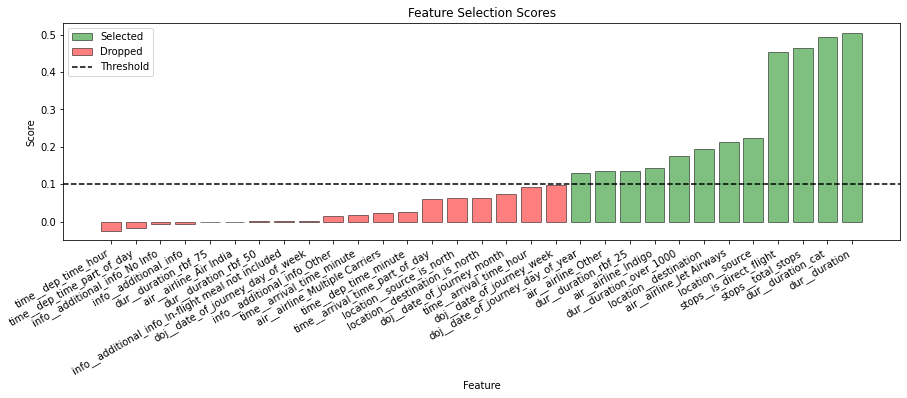

In [57]:
THRESHOLD = 0.095

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
    params = dict(
        x=i,
        height=score,
        edgecolor="black",
        alpha=0.5
    )
    
    if score < THRESHOLD:
        bar = ax.bar(
            color="red",
            **params
        )
        if not dropped_bar:
            dropped_bar = bar[0]
    else:
        bar = ax.bar(
            color="green",
            **params
        )
        if not selected_bar:
            selected_bar = bar[0]

thresh_line = ax.axhline(
    y=0.1,
    color="black",
    linestyle="--"
)

ax.set_xticks(
    ticks=range(len(sorted_feat_imp)),
    labels=list(sorted_feat_imp.keys()),
    rotation=30,
    ha="right"
)

ax.set(
    xlabel="Feature",
    ylabel="Score",
    title="Feature Selection Scores"
)

ax.legend(
    handles=[selected_bar, dropped_bar, thresh_line],
    labels=["Selected", "Dropped", "Threshold"],
    loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that

In [58]:
import pickle
with open("xgboost-model","rb") as f:
    best_model = pickle.load(f)

best_model

In [59]:
import xgboost as xgb
from sklearn.metrics import r2_score

In [60]:
def evaluate_model(name):
    
    X = xgb.DMatrix(temp)
    y = train.iloc[:,-1]
    
    pred = best_model.predict(X)
    
    return r2_score(y,pred)